# Train model with Scikit-Learn, XGBoost

input-output summary
```
f(user_info, user's transaction, portfolio) = y
```

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score, accuracy_score

import xgboost as xgb
import pickle

In [25]:
profile = pd.read_csv("data/profile.csv")
portfolio = pd.read_csv("data/portfolio-dummy.csv")
train_set = pd.read_csv("data/train.csv")
test_set = pd.read_csv("data/test.csv")
train_transactions = pd.read_csv("data/train_transactions.csv")
test_transactions = pd.read_csv("data/test_transactions.csv")

In [26]:
def encode_dataset(df, transactions, shuffle=False):
    """
        load dataset
    """
    df = df.merge(profile, left_on='person', right_on='id') \
        .merge(portfolio, left_on='offer_id', right_on="id") \
        .merge(transactions, left_on='person', right_on='person')
    if shuffle:
        df = df.sample(frac=1)
    df.index = df[['person', 'offer_id']]
    
    y = df['offer viewed']
    df = df.drop(columns=['person', 'offer_id', 'id_x', 'id_y', 'offer viewed', "member_since", "email"])
    df.amount = np.log(df.amount)
    return df, y

X_train, y_train = encode_dataset(train_set, train_transactions, True)
X_test, y_test = encode_dataset(test_set, test_transactions, False)
X_train

,age,income,not_na,gender_F,gender_M,gender_O,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,amount
"(40bb30fe65624a638d3148dfb4af92d9, 4d5c57ea9a6940dd891ad53e9dbe8da0)",73.000000,71000.000000,1,0,0,1,10,10,5,1.0,1.0,1.0,1,0,0,3.874736
"(61b8c67126e2471892b7336b0bb58f11, 0b1e1539f2cc45b7b9fa7c272da2e1d7)",82.000000,65000.000000,1,0,1,0,5,20,10,0.0,0.0,1.0,0,1,0,4.564348
"(54f2fd27d5aa4cfd822219e833cc2af3, 3f207df678b143eea3cee63160fa8bed)",55.000000,108000.000000,1,0,1,0,0,0,4,1.0,0.0,1.0,0,0,1,4.981756
"(50957b9a771f4e5d9df530c13a1184f1, 4d5c57ea9a6940dd891ad53e9dbe8da0)",50.000000,48000.000000,1,1,0,0,10,10,5,1.0,1.0,1.0,1,0,0,6.142919
"(41576d9278374b85be60bb9c2ebb2db1, 5a8bc65990b245e5a138643cd4eb9837)",21.000000,56000.000000,1,0,1,0,0,0,3,1.0,1.0,0.0,0,0,1,2.278292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(09a232cdf36d4d2b9d23a860493ce998, 2298d6c36e964ae4a3e7e9706d1fb8c2)",67.000000,36000.000000,1,0,1,0,3,7,7,1.0,1.0,1.0,0,1,0,4.265914
"(d12bcab81d0e4479817a2c0cbd9909a6, fafdcd668e3743c1bb461111dcafc2a4)",34.000000,53000.000000,1,0,1,0,2,10,10,1.0,1.0,1.0,0,1,0,4.975077
"(1218e2bc59f64a619f3503e9c8b76f9d, fafdcd668e3743c1bb461111dcafc2a4)",54.393524,65404.991568,0,0,0,0,2,10,10,1.0,1.0,1.0,0,1,0,2.700690
"(01ab25c31f034f85bc4ac9d286fb7a76, fafdcd668e3743c1bb461111dcafc2a4)",87.000000,77000.000000,1,1,0,0,2,10,10,1.0,1.0,1.0,0,1,0,6.377900


<AxesSubplot:ylabel='Frequency'>

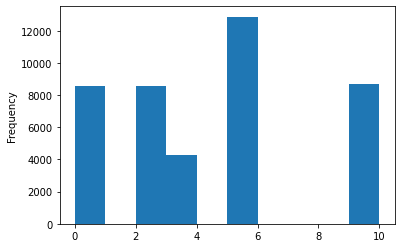

In [27]:
# np.log(X_train.amount).plot.hist()
X_train.reward.plot.hist()

In [49]:
def get_xgb():
    pipe = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('xgb', xgb.XGBClassifier())
        ]
    )
    
    return pipe

def get_baseline():
    pipe = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('clf', RandomForestClassifier())
        ]
    )
    
    return pipe

def get_xgb_gcv():
    
    param_grid = {
        'xgb__booster' :['gbtree'],
        'xgb__max_depth':[5,6,8],
        'xgb__min_child_weight':[1,3,5],
        'xgb__gamma':[0,1,2,3],
        'xgb__nthread':[4],
        'xgb__colsample_bytree':[0.5,0.8],
        'xgb__colsample_bylevel':[0.9],
        'xgb__n_estimators':[5, 10, 15, 25, 50],
        'xgb__objective':['binary:logistic'],
        'xgb__random_state':[2]
    }
    
    pipe = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('xgb', xgb.XGBClassifier())
        ]
    )
    gcv=GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=10)
    
    return gcv

In [31]:
def train_and_test(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    print("Report for", name)
    print("Train Report>")
    print("Train Accuracy:", model.score(X_train, y_train))
    y_pred = model.predict(X_train)
    print(classification_report(y_train, y_pred))
    
    print("Test Report>")
    print("Test Accuracy:", model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    if model is GridSearchCV:
        print("Best Parameter")
        print(model.best_params_)
        
    # save model
    with open(f"model/{name}.pkl", "wb") as f:
        pickle.dump(model, f)

In [32]:
%time
baseline_model = get_baseline()
train_and_test("baseline", baseline_model, X_train, y_train, X_test, y_test)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
Report for baseline
Train Report>
Train Accuracy: 0.9978115614741695
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      9886
         1.0       1.00      1.00      1.00     33067

    accuracy                           1.00     42953
   macro avg       1.00      1.00      1.00     42953
weighted avg       1.00      1.00      1.00     42953

Test Report>
Test Accuracy: 0.8160577356788453
              precision    recall  f1-score   support

         0.0       0.62      0.61      0.62      5362
         1.0       0.88      0.88      0.88     16808

    accuracy                           0.82     22170
   macro avg       0.75      0.75      0.75     22170
weighted avg       0.82      0.82      0.82     22170

Best Parameter


In [33]:
simple_model = get_xgb()
train_and_test("simple", simple_model, X_train, y_train, X_test, y_test)

Report for simple
Train Report>
Train Accuracy: 0.8701836891486043
              precision    recall  f1-score   support

         0.0       0.77      0.62      0.69      9886
         1.0       0.89      0.94      0.92     33067

    accuracy                           0.87     42953
   macro avg       0.83      0.78      0.80     42953
weighted avg       0.86      0.87      0.87     42953

Test Report>
Test Accuracy: 0.8285069914298602
              precision    recall  f1-score   support

         0.0       0.66      0.60      0.63      5362
         1.0       0.88      0.90      0.89     16808

    accuracy                           0.83     22170
   macro avg       0.77      0.75      0.76     22170
weighted avg       0.82      0.83      0.83     22170

Best Parameter


In [50]:
model = get_xgb_gcv()

In [51]:
%time
train_and_test("xgb-gcv-refined2", model, X_train, y_train, X_test, y_test)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
Report for xgb-gcv-refined2
Train Report>
Train Accuracy: 0.9078507305051928
              precision    recall  f1-score   support

         0.0       0.73      0.58      0.65      9886
         1.0       0.88      0.94      0.91     33067

    accuracy                           0.85     42953
   macro avg       0.81      0.76      0.78     42953
weighted avg       0.85      0.85      0.85     42953

Test Report>
Test Accuracy: 0.8910629296668429
              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64      5362
         1.0       0.88      0.90      0.89     16808

    accuracy                           0.83     22170
   macro avg       0.77      0.76      0.77     22170
weighted avg       0.83      0.83      0.83     22170

Best Parameter


In [93]:
model.best_params_

{'xgb__booster': 'gbtree',
 'xgb__colsample_bylevel': 0.9,
 'xgb__colsample_bytree': 0.8,
 'xgb__gamma': 1,
 'xgb__max_depth': 6,
 'xgb__min_child_weight': 3,
 'xgb__n_estimators': 50,
 'xgb__nthread': 4,
 'xgb__objective': 'binary:logistic',
 'xgb__random_state': 2}

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

# Evaluation: Let's see what's correct or not

In [9]:
def show_df_dist(df):
    for c in df.columns:
        df[c].plot.hist(title=c)
        plt.show()

In [54]:
# get true positive, true negative, false positive, false negative, 

def get_1(X, y_true, y_pred, true_val, pred_val):
    return X.loc[y_pred[(y_true == true_val) & (y_pred == pred_val)].index]

def get_error(model, X, y):
    y_true = y
    y_pred = pd.Series(model.predict(X), index=y.index)
    
    tp = get_1(X, y_true, y_pred, 1, 1)
    tn = get_1(X, y_true, y_pred, 1, 0)
    fp = get_1(X, y_true, y_pred, 0, 1)
    fn = get_1(X, y_true, y_pred, 0, 0)
    
    total = X.copy()
    total["group"] = "total"
    corrects = pd.concat([tp, fn], axis=0)
    corrects["group"] = "correct"
    wrongs = pd.concat([tn, fp], axis=0)
    wrongs["group"] = "wrong"
    
    return pd.concat([total, corrects, wrongs], axis=0)

In [57]:
errors = get_error(model, X_test, y_test)
errors

,age,income,not_na,gender_F,gender_M,gender_O,reward,difficulty,duration,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,amount,group
"(0009655768c64bdeb2e877511632db8f, 2906b810c7d4411798c6938adc9daaa5)",33.000000,72000.000000,1,0,1,0,2,10,7,1.0,0.0,1.0,0,1,0,4.573370,total
"(0009655768c64bdeb2e877511632db8f, fafdcd668e3743c1bb461111dcafc2a4)",33.000000,72000.000000,1,0,1,0,2,10,10,1.0,1.0,1.0,0,1,0,4.573370,total
"(00426fe3ffde4c6b9cb9ad6d077a13ea, 2906b810c7d4411798c6938adc9daaa5)",19.000000,65000.000000,1,1,0,0,2,10,7,1.0,0.0,1.0,0,1,0,1.781709,total
"(0069a50874d846438e58acff5e594725, 2906b810c7d4411798c6938adc9daaa5)",54.393524,65404.991568,0,0,0,0,2,10,7,1.0,0.0,1.0,0,1,0,2.571849,total
"(00715b6e55c3431cb56ff7307eb19675, 2906b810c7d4411798c6938adc9daaa5)",58.000000,119000.000000,1,1,0,0,2,10,7,1.0,0.0,1.0,0,1,0,4.216857,total
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(8546af2069ef41d2adbb52db78b93e47, 4d5c57ea9a6940dd891ad53e9dbe8da0)",22.000000,56000.000000,1,0,1,0,10,10,5,1.0,1.0,1.0,1,0,0,1.710188,wrong
"(9ba4cd53968544ea8a682c11b8b8b63e, 4d5c57ea9a6940dd891ad53e9dbe8da0)",49.000000,98000.000000,1,0,1,0,10,10,5,1.0,1.0,1.0,1,0,0,2.821974,wrong
"(a25edbd49eee4c5cbdaf2930cefb4634, 4d5c57ea9a6940dd891ad53e9dbe8da0)",22.000000,35000.000000,1,0,1,0,10,10,5,1.0,1.0,1.0,1,0,0,3.659451,wrong
"(a6105ca2ed8f4ce4b1b73f98b9b82c3a, 4d5c57ea9a6940dd891ad53e9dbe8da0)",28.000000,53000.000000,1,0,1,0,10,10,5,1.0,1.0,1.0,1,0,0,2.470639,wrong


## Compare distribution of corrects or not 
For finding how to improve my model

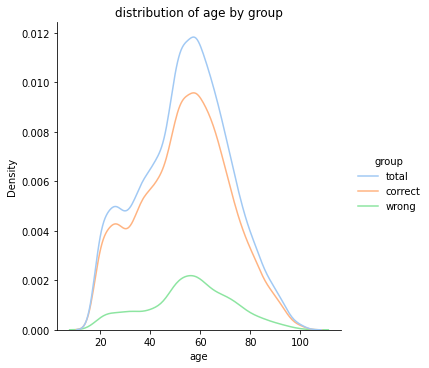

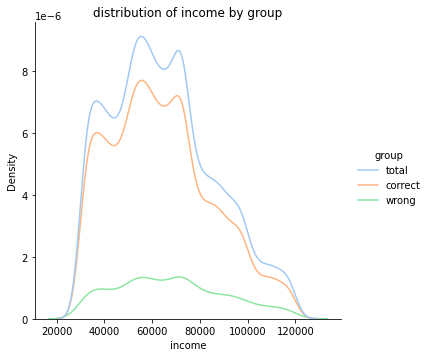

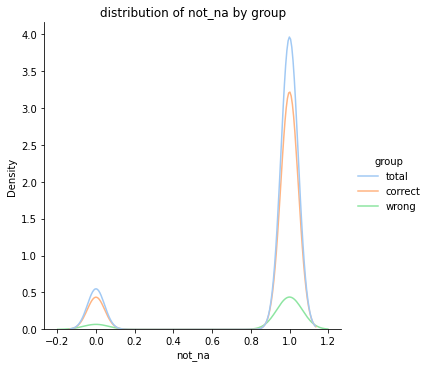

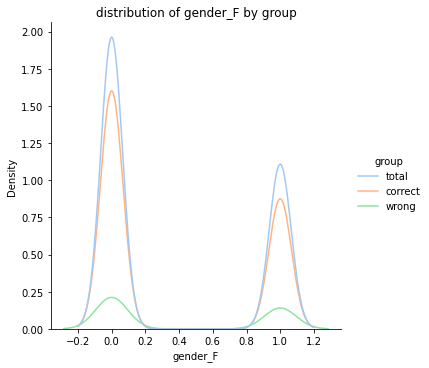

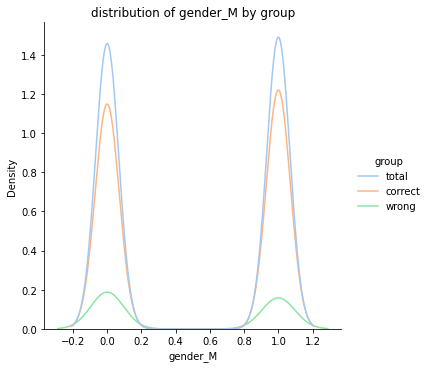

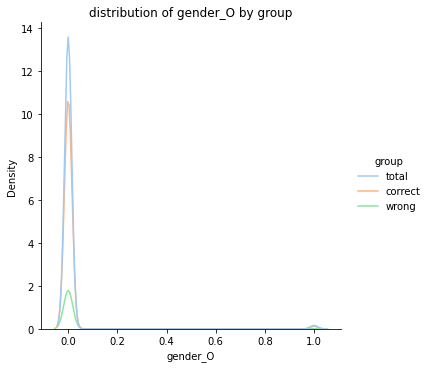

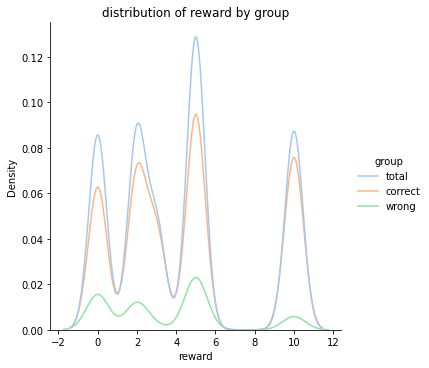

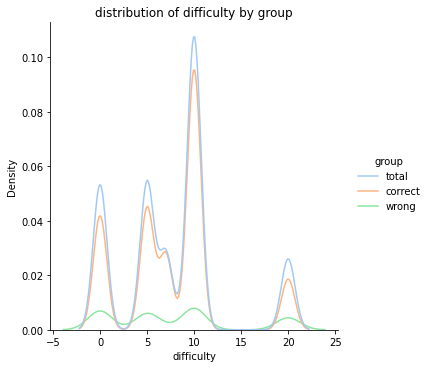

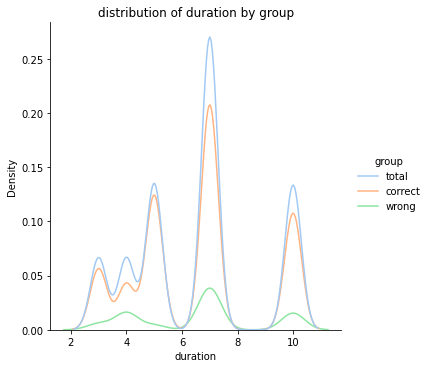

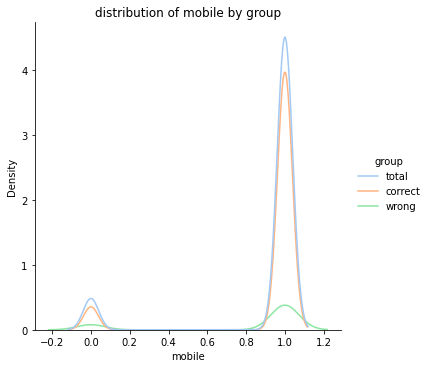

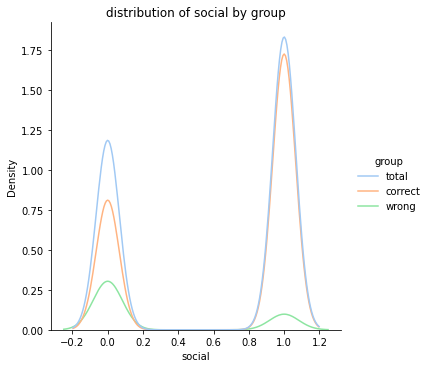

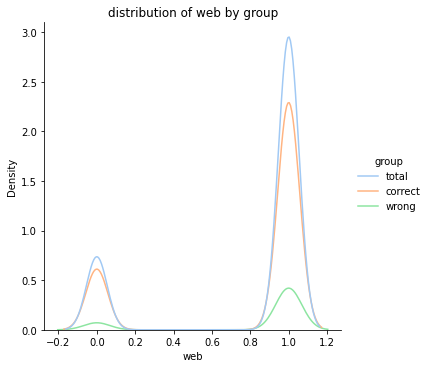

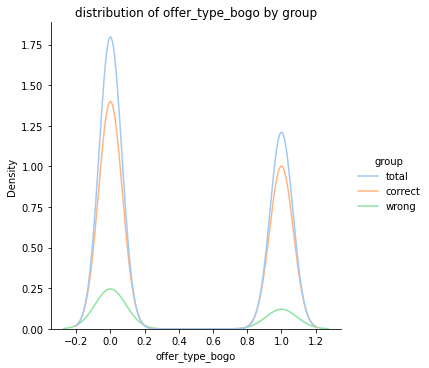

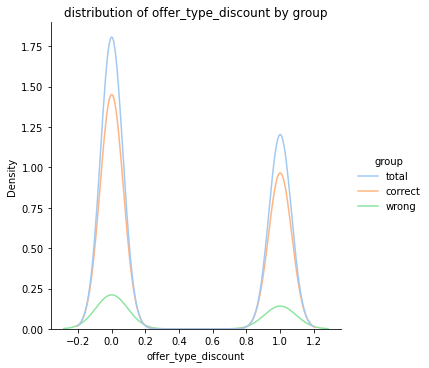

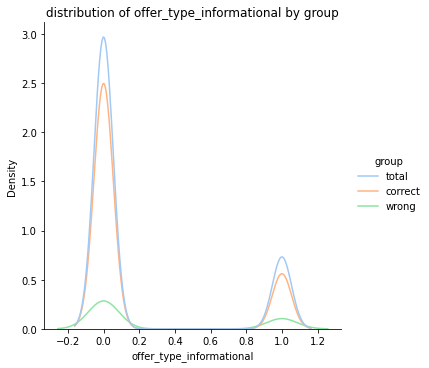

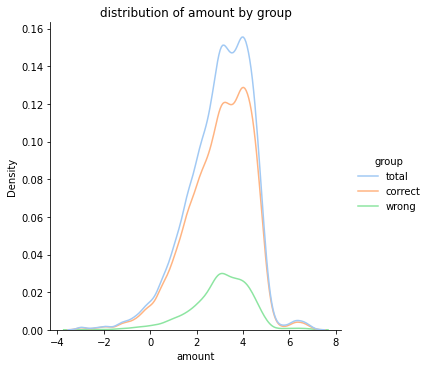

In [71]:
for col in errors.columns:
    if col == "group":
        continue
    
    if col in ["age", "income"]:
        data = errors[errors.not_na == 1]
    else:
        data = errors
        
    sns.displot(data=data, x=col, hue="group", palette="pastel", kind="kde", hue_norm=data.groupby("group").count()[col])
        
    plt.title(f"distribution of {col} by group")
    plt.show()

In [109]:
def threshold_test(model, X, y, threshold):
    y_pred = model.predict_proba(X)[:, 1]
    y_pred = list(map(lambda x: 1 if x > threshold else 0, y_pred))

    return accuracy_score(y_pred, y), f1_score(y_pred, y)

pd.DataFrame(
    [threshold_test(model, X_test, y_test, i / 10) for i in range(2, 9)], 
    columns = ["accuracy", "f1 score"],
    index=list(map(lambda x: x / 10, range(2, 9)))
)

,accuracy,f1 score
0.2,0.805323,0.884685
0.3,0.828101,0.894738
0.4,0.833153,0.895120
0.5,0.832747,0.891063
0.6,0.823230,0.880929
0.7,0.796888,0.856952
0.8,0.763013,0.824972


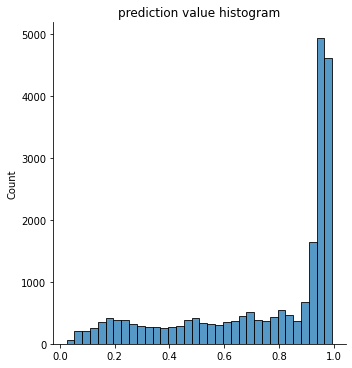

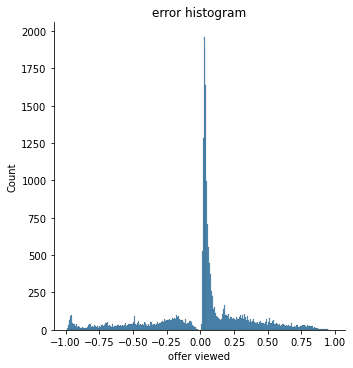

In [79]:
# test error distribution

def prediction_error_hist(model, X, y):
    y_pred = model.predict_proba(X)[:, 1]
    
    # prediction value histogram
    sns.displot(y_pred)
    plt.title("prediction value histogram")
    plt.show()
    
    # error histogram
    error = y - y_pred
    sns.displot(error)
    plt.title("error histogram")
    plt.show()
    
prediction_error_hist(model, X_test, y_test)

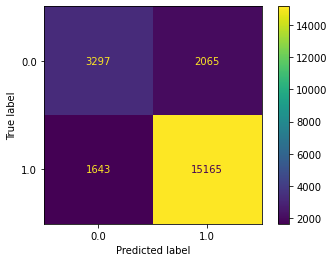

In [80]:
plot_confusion_matrix(model, X_test, y_test)

/Users/hg_kim/.pyenv/versions/3.6.10/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  import sys


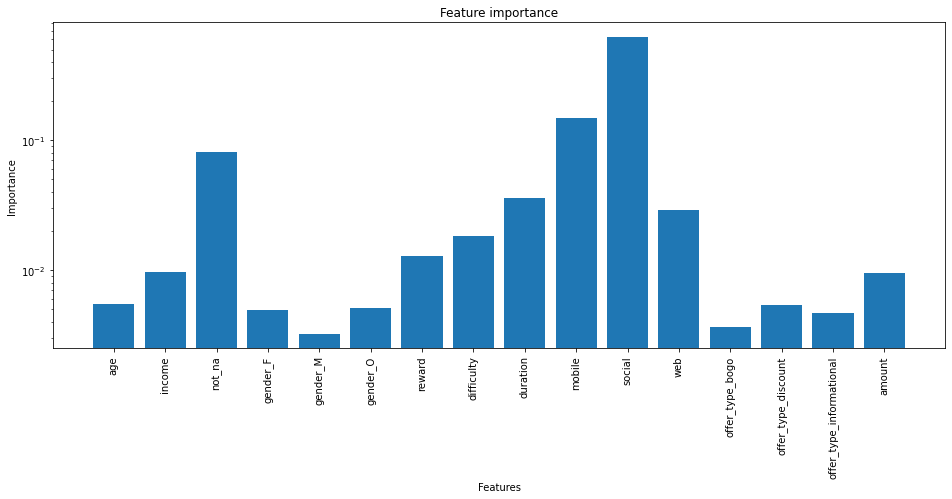

In [81]:
def plot_feature_importance(model, features):
    """
    """
    
    feature_importance = model.feature_importances_
    plt.figure(figsize=(16, 6))
    plt.yscale('log', nonposy='clip')
    plt.bar(range(len(feature_importance)), feature_importance, align='center')
    plt.xticks(range(len(feature_importance)), features, rotation='vertical')
    plt.title('Feature importance')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.show()
    
# model.named_steps['xgb']
plot_feature_importance(model.best_estimator_.named_steps['xgb'], X_test.columns)

Confusion matrix for not_na


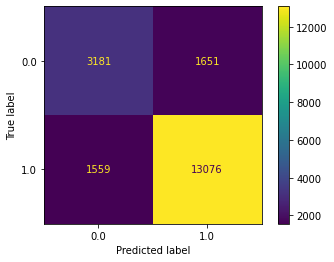

Accuracy:  0.8906750221374565
              precision    recall  f1-score   support

         0.0       0.67      0.66      0.66      4832
         1.0       0.89      0.89      0.89     14635

    accuracy                           0.84     19467
   macro avg       0.78      0.78      0.78     19467
weighted avg       0.83      0.84      0.83     19467

Confusion matrix for na


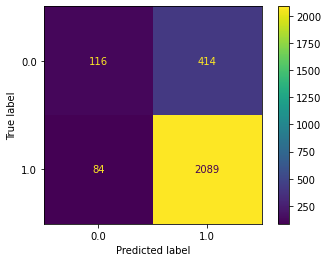

Accuracy:  0.8934987168520103
              precision    recall  f1-score   support

         0.0       0.58      0.22      0.32       530
         1.0       0.83      0.96      0.89      2173

    accuracy                           0.82      2703
   macro avg       0.71      0.59      0.61      2703
weighted avg       0.78      0.82      0.78      2703



In [92]:
def print_score_report_and_confusion_matrix(title, X, y):
    print("Confusion matrix for", title)
    plot_confusion_matrix(model, X, y)
    plt.show()

    print("Accuracy: ", model.score(X, y))
    print(classification_report(y, model.predict(X)))

X_test_not_na = X_test.loc[X_test.not_na == 1]
y_test_not_na = y_test.loc[X_test.not_na == 1]
print_score_report_and_confusion_matrix("not_na", X_test_not_na, y_test_not_na)


X_test_na = X_test.loc[X_test.not_na == 0]
y_test_na = y_test.loc[X_test.not_na == 0]
print_score_report_and_confusion_matrix("na", X_test_na, y_test_na)